In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

2024-10-13 10:43:01.232117: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-13 10:43:01.232200: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-13 10:43:01.232241: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-13 10:43:01.241597: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
!pip install --upgrade matplotlib seaborn numpy

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 24.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 10.9 MB/s eta 0:00:0000:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.12.0 requires numpy<1.25,>=1.21, but you have numpy 1.26.4 which is incompatible.
dask-cudf 23.12.0 requires numpy<1.25,>=1.21, but you have numpy 1.26.4 which is incompatible.
numba 0.57.1+1.gb7ee25572 requires numpy<1.25,>=1.21, but you have numpy 1.26.4 which is incompatible.


In [3]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import scale


import numpy as np
import pandas as pd

In [4]:
df = pd.read_csv("/home/work/gnssl/cleaned_improved_cicids2017.csv")

In [5]:
df.head()

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
0,0,119719148,231,0,0,0,0,0,0.000000,0.000000,...,22509459,17,12685486.0,5.296658e+06,20694308,6499982,0,0,0,BENIGN
1,17,65511209,6,6,288,288,48,48,48.000000,0.000000,...,1506210,1506210,64004884.0,0.000000e+00,64004884,64004884,0,0,0,BENIGN
2,17,113976922,267,0,20447,0,153,37,76.580524,44.140625,...,10983883,14,25498178.0,1.883305e+07,48523116,5463561,0,0,0,BENIGN
3,17,67037196,8,8,384,384,48,48,48.000000,0.000000,...,11034681,11034681,55956316.0,0.000000e+00,55956316,55956316,0,0,0,BENIGN
4,17,68045057,8,8,384,384,48,48,48.000000,0.000000,...,11043596,11043596,56943904.0,0.000000e+00,56943904,56943904,0,0,0,BENIGN


In [6]:
df['Label'].value_counts()

BENIGN                        1594540
Portscan                       159066
DoS Hulk                       158468
DDoS                            95144
Infiltration - Portscan         71767
DoS GoldenEye                    7567
FTP-Patator                      3972
DoS Slowloris                    3859
SSH-Patator                      2961
DoS Slowhttptest                 1740
Botnet                            736
Web Attack - Brute Force           73
Infiltration                       36
Web Attack - XSS                   18
Web Attack - SQL Injection         13
Heartbleed                         11
Name: Label, dtype: int64

In [7]:
df.isnull().values.any()

False

In [8]:
len(df.columns)

83

In [9]:
df.shape

(2099971, 83)

In [10]:
from sklearn.preprocessing import LabelEncoder

# Label Encoding 적용
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])


# 인코딩된 데이터프레임 확인
print(df['Label'].value_counts())

0     1594540
11     159066
4      158468
2       95144
10      71767
3        7567
7        3972
6        3859
12       2961
5        1740
1         736
13         73
9          36
15         18
14         13
8          11
Name: Label, dtype: int64


In [11]:
df.columns

Index(['Protocol', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets',
       'Total Length of Fwd Packet', 'Total Length of Bwd Packet',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd RST Flags',
       'Bwd RST Flags', 'Fwd Header Length', 'Bwd Header Length',
       'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min',
       'Packet Length Max', 'Packet Length Mean', 'Packet Length Std',
       'Packet Length Variance', 'FIN Flag Count', '

In [12]:
# 0과 11만 필터링
filtered_df = df[df['Label'].isin([0, 6])]

# 11을 1로 변환
filtered_df['Label'] = filtered_df['Label'].replace(6, 1)

df = filtered_df

/tmp/ipykernel_130/583376035.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Label'] = filtered_df['Label'].replace(6, 1)


In [13]:
df['Label'].value_counts()

0    1594540
1       3859
Name: Label, dtype: int64

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df, test_size=0.1, random_state=42)
X_train.shape, X_test.shape

((1438559, 83), (159840, 83))

In [15]:
X_train_normal = X_train[X_train['Label'] == 0]
X_train_normal.shape

X_test_normal = X_test[X_test['Label'] == 0]
X_test_normal.shape

(159474, 83)

In [16]:
X_train_not_normal = X_train[X_train['Label'] !=0]

X_test = pd.concat([X_test, X_train_not_normal])

In [17]:
X_test.shape

(163333, 83)

In [18]:
X_test['Label'].value_counts()

0    159474
1      3859
Name: Label, dtype: int64

In [19]:
!pip install --upgrade scikit-learn
!pip install --upgrade imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 41.0 MB/s eta 0:00:0000:0100:01
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 6.4 MB/s eta 0:00:00a 0:00:01


In [20]:
from imblearn.over_sampling import SMOTE

# X와 y 분리
X = X_test.drop('Label', axis=1)
y = X_test['Label']

# SMOTE 적용 (1:0.75 비율로 맞추기)
smote = SMOTE(sampling_strategy=0.75, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 다시 합쳐서 새로운 데이터셋 생성
X_test_balanced = pd.concat([X_resampled, y_resampled], axis=1)

In [21]:
X_test_balanced['Label'].value_counts()

0    159474
1    119605
Name: Label, dtype: int64

In [22]:
X_test = X_test_balanced

In [23]:
y_test = X_test['Label']
X_test = X_test.drop(labels='Label',axis=1)

In [24]:
y_train_normal = X_train_normal['Label']
X_train_normal = X_train_normal.drop(labels='Label', axis=1)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_normal = scaler.fit_transform(X_train_normal)
X_test = scaler.fit_transform(X_test_balanced)

In [25]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_normal = scaler.fit_transform(X_train_normal)
X_test = scaler.fit_transform(X_test)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_normal = scaler.fit_transform(X_train_normal)
X_test = scaler.fit_transform(X_test)

In [26]:
!pip install keras_self_attention

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
  Created wheel for keras_self_attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=84df68f518103a3139aafa3b7f5b204e3a83a1a88040a62e20980fed3419f5dc
  Stored in directory: /home/work/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras_self_attention


In [27]:
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector, Conv1D, Conv1DTranspose
from keras.models import Model
from keras import regularizers
from keras_self_attention import SeqWeightedAttention, SeqSelfAttention
from keras.callbacks import EarlyStopping

In [28]:
import tensorflow as tf
from tensorflow.keras import layers, losses, Model, Input
import numpy as np
from tensorflow.keras import backend as K

latent_dim = 10
inter_dim = 20

# Sampling function for reparameterization trick
def sampling(args):
    z_mean, z_log_sigma = args
    batch_size = tf.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
    return z_mean + z_log_sigma * epsilon

def vae_loss(x, x_decoded_mean, z_mean, z_log_sigma):
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean), axis=1)
    kl_loss = -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    kl_loss_weighted = kl_loss * 0.0001  # KL 다이버전스 손실에 가중치 부여
    total_loss = K.mean(reconstruction_loss + kl_loss_weighted)
    return total_loss

def cvae(X, labels):
    features = X.shape[1]  # 2D 데이터이므로 timesteps는 필요 없고, features만 사용
    input_x = Input(shape=(features,), name='InputFeatures')  # 2D 입력 (샘플, 특징)

    input_label = Input(shape=(1,), name='InputLabel')  # Assumes binary or multi-class label

    # Embed the label into the same shape as the input
    embedded_label = layers.Embedding(input_dim=2, output_dim=features)(input_label)  # Adjust output_dim to match features
    embedded_label = layers.Flatten()(embedded_label)

    # Concatenate input_x and embedded_label
    concatenated_input = layers.Concatenate()([input_x, embedded_label])

    # Reshape for Conv1D layer (to 3D)
    reshaped_input = layers.Reshape((features + embedded_label.shape[-1], 1))(concatenated_input)

    # Encoder with CNN layers
    h = layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding='same')(reshaped_input)
    h = layers.Conv1D(filters=32, kernel_size=3, activation="relu", padding='same')(h)
    h = layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same')(h)

    # Flatten for dense layers (MLP)
    h = layers.Flatten()(h)
    h = layers.Dense(inter_dim, activation='relu')(h)
    h = layers.Dense(inter_dim, activation='relu')(h)

    # z layer
    z_mean = layers.Dense(latent_dim)(h)
    z_log_sigma = layers.Dense(latent_dim)(h)
    z = layers.Lambda(sampling)([z_mean, z_log_sigma])

    # Decoder
    # Add the label to the latent space z
    z_with_label = layers.Concatenate()([z, embedded_label])

    # Expand for Conv1DTranspose layer
    decoder1 = layers.Dense((features + embedded_label.shape[-1]) * inter_dim)(z_with_label)
    decoder1 = layers.Reshape((features + embedded_label.shape[-1], inter_dim))(decoder1)

    # Decoder with CNN layers
    decoder1 = layers.Conv1DTranspose(filters=16, kernel_size=3, activation="relu", padding='same')(decoder1)
    decoder1 = layers.Conv1DTranspose(filters=32, kernel_size=3, activation="relu", padding='same')(decoder1)
    decoder1 = layers.Conv1DTranspose(filters=64, kernel_size=3, activation="relu", padding='same')(decoder1)

    # Flatten and final dense layer to reconstruct original features
    decoder1 = layers.Flatten()(decoder1)
    decoder1 = layers.Dense(features)(decoder1)
    
    model = Model([input_x, input_label], decoder1)
    model.add_loss(vae_loss(input_x, decoder1, z_mean, z_log_sigma))
    
    return model

# Create CVAE model
model = cvae(X_train_normal, y_train_normal)
model.summary()

from tensorflow.keras.callbacks import EarlyStopping
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])
# Create an EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile and train the model with early stopping
history = model.fit([X_train_normal, y_train_normal], X_train_normal,
                    shuffle=True,
                    epochs=50, 
                    validation_split=0.1,  
                    batch_size=32,
                    callbacks=[early_stopping]).history
'''
# Compile and train the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])
history = model.fit([X_train_normal, y_train_normal], X_train_normal,
                    shuffle=True,
                    epochs=50, 
                    validation_split=0.1,  
                    batch_size=32).history  
'''


2024-10-13 10:43:46.685633: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38698 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:4c:00.0, compute capability: 8.0
2024-10-13 10:43:46.687939: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38698 MB memory:  -> device: 1, name: CUDA GPU, pci bus id: 0000:88:00.0, compute capability: 8.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 InputLabel (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 82)                164       ['InputLabel[0][0]']          
                                                                                                  
 InputFeatures (InputLayer)  [(None, 82)]                 0         []                            
                                                                                                  
 flatten (Flatten)           (None, 82)                   0         ['embedding[0][0]']           
                                                                                              

                                                                                                  
 tf.math.multiply_1 (TFOpLa  (None,)                      0         ['tf.math.multiply[0][0]']    
 mbda)                                                                                            
                                                                                                  
 tf.__operators__.add_1 (TF  (None,)                      0         ['tf.math.reduce_sum[0][0]',  
 OpLambda)                                                           'tf.math.multiply_1[0][0]']  
                                                                                                  
 tf.math.reduce_mean (TFOpL  ()                           0         ['tf.__operators__.add_1[0][0]
 ambda)                                                             ']                            
                                                                                                  
 add_loss 

2024-10-13 10:43:50.249856: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-10-13 10:43:50.975210: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x562b9923bd00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-13 10:43:50.975262: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): CUDA GPU, Compute Capability 8.0
2024-10-13 10:43:50.975269: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): CUDA GPU, Compute Capability 8.0
2024-10-13 10:43:50.980559: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-13 10:43:51.063607: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40362/40362 [==============================] - 263s 6ms/step - loss: 0.0075 - accuracy: 0.9176 - val_loss: 0.0020 - val_accuracy: 0.9238
Epoch 2/50
40362/40362 [==============================] - 257s 6ms/step - loss: 0.0019 - accuracy: 0.9217 - val_loss: 0.0013 - val_accuracy: 0.8975
Epoch 3/50
40362/40362 [==============================] - 257s 6ms/step - loss: 0.0014 - accuracy: 0.9225 - val_loss: 0.0011 - val_accuracy: 0.9439
Epoch 4/50
40362/40362 [==============================] - 258s 6ms/step - loss: 0.0012 - accuracy: 0.9235 - val_loss: 9.0187e-04 - val_accuracy: 0.9232
Epoch 5/50
40362/40362 [==============================] - 257s 6ms/step - loss: 0.0011 - accuracy: 0.9231 - val_loss: 8.7208e-04 - val_accuracy: 0.9186
Epoch 6/50
40362/40362 [==============================] - 259s 6ms/step - loss: 9.9152e-04 - accuracy: 0.9241 - val_loss: 0.0015 - val_accuracy: 0.9194
Epoch 7/50
40362/40362 [==============================] - 257s 6ms/step - loss: 9.3376e-04 - accuracy: 0.9250 -

"\n# Compile and train the model\nmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])\nhistory = model.fit([X_train_normal, y_train_normal], X_train_normal,\n                    shuffle=True,\n                    epochs=50, \n                    validation_split=0.1,  \n                    batch_size=32).history  \n"

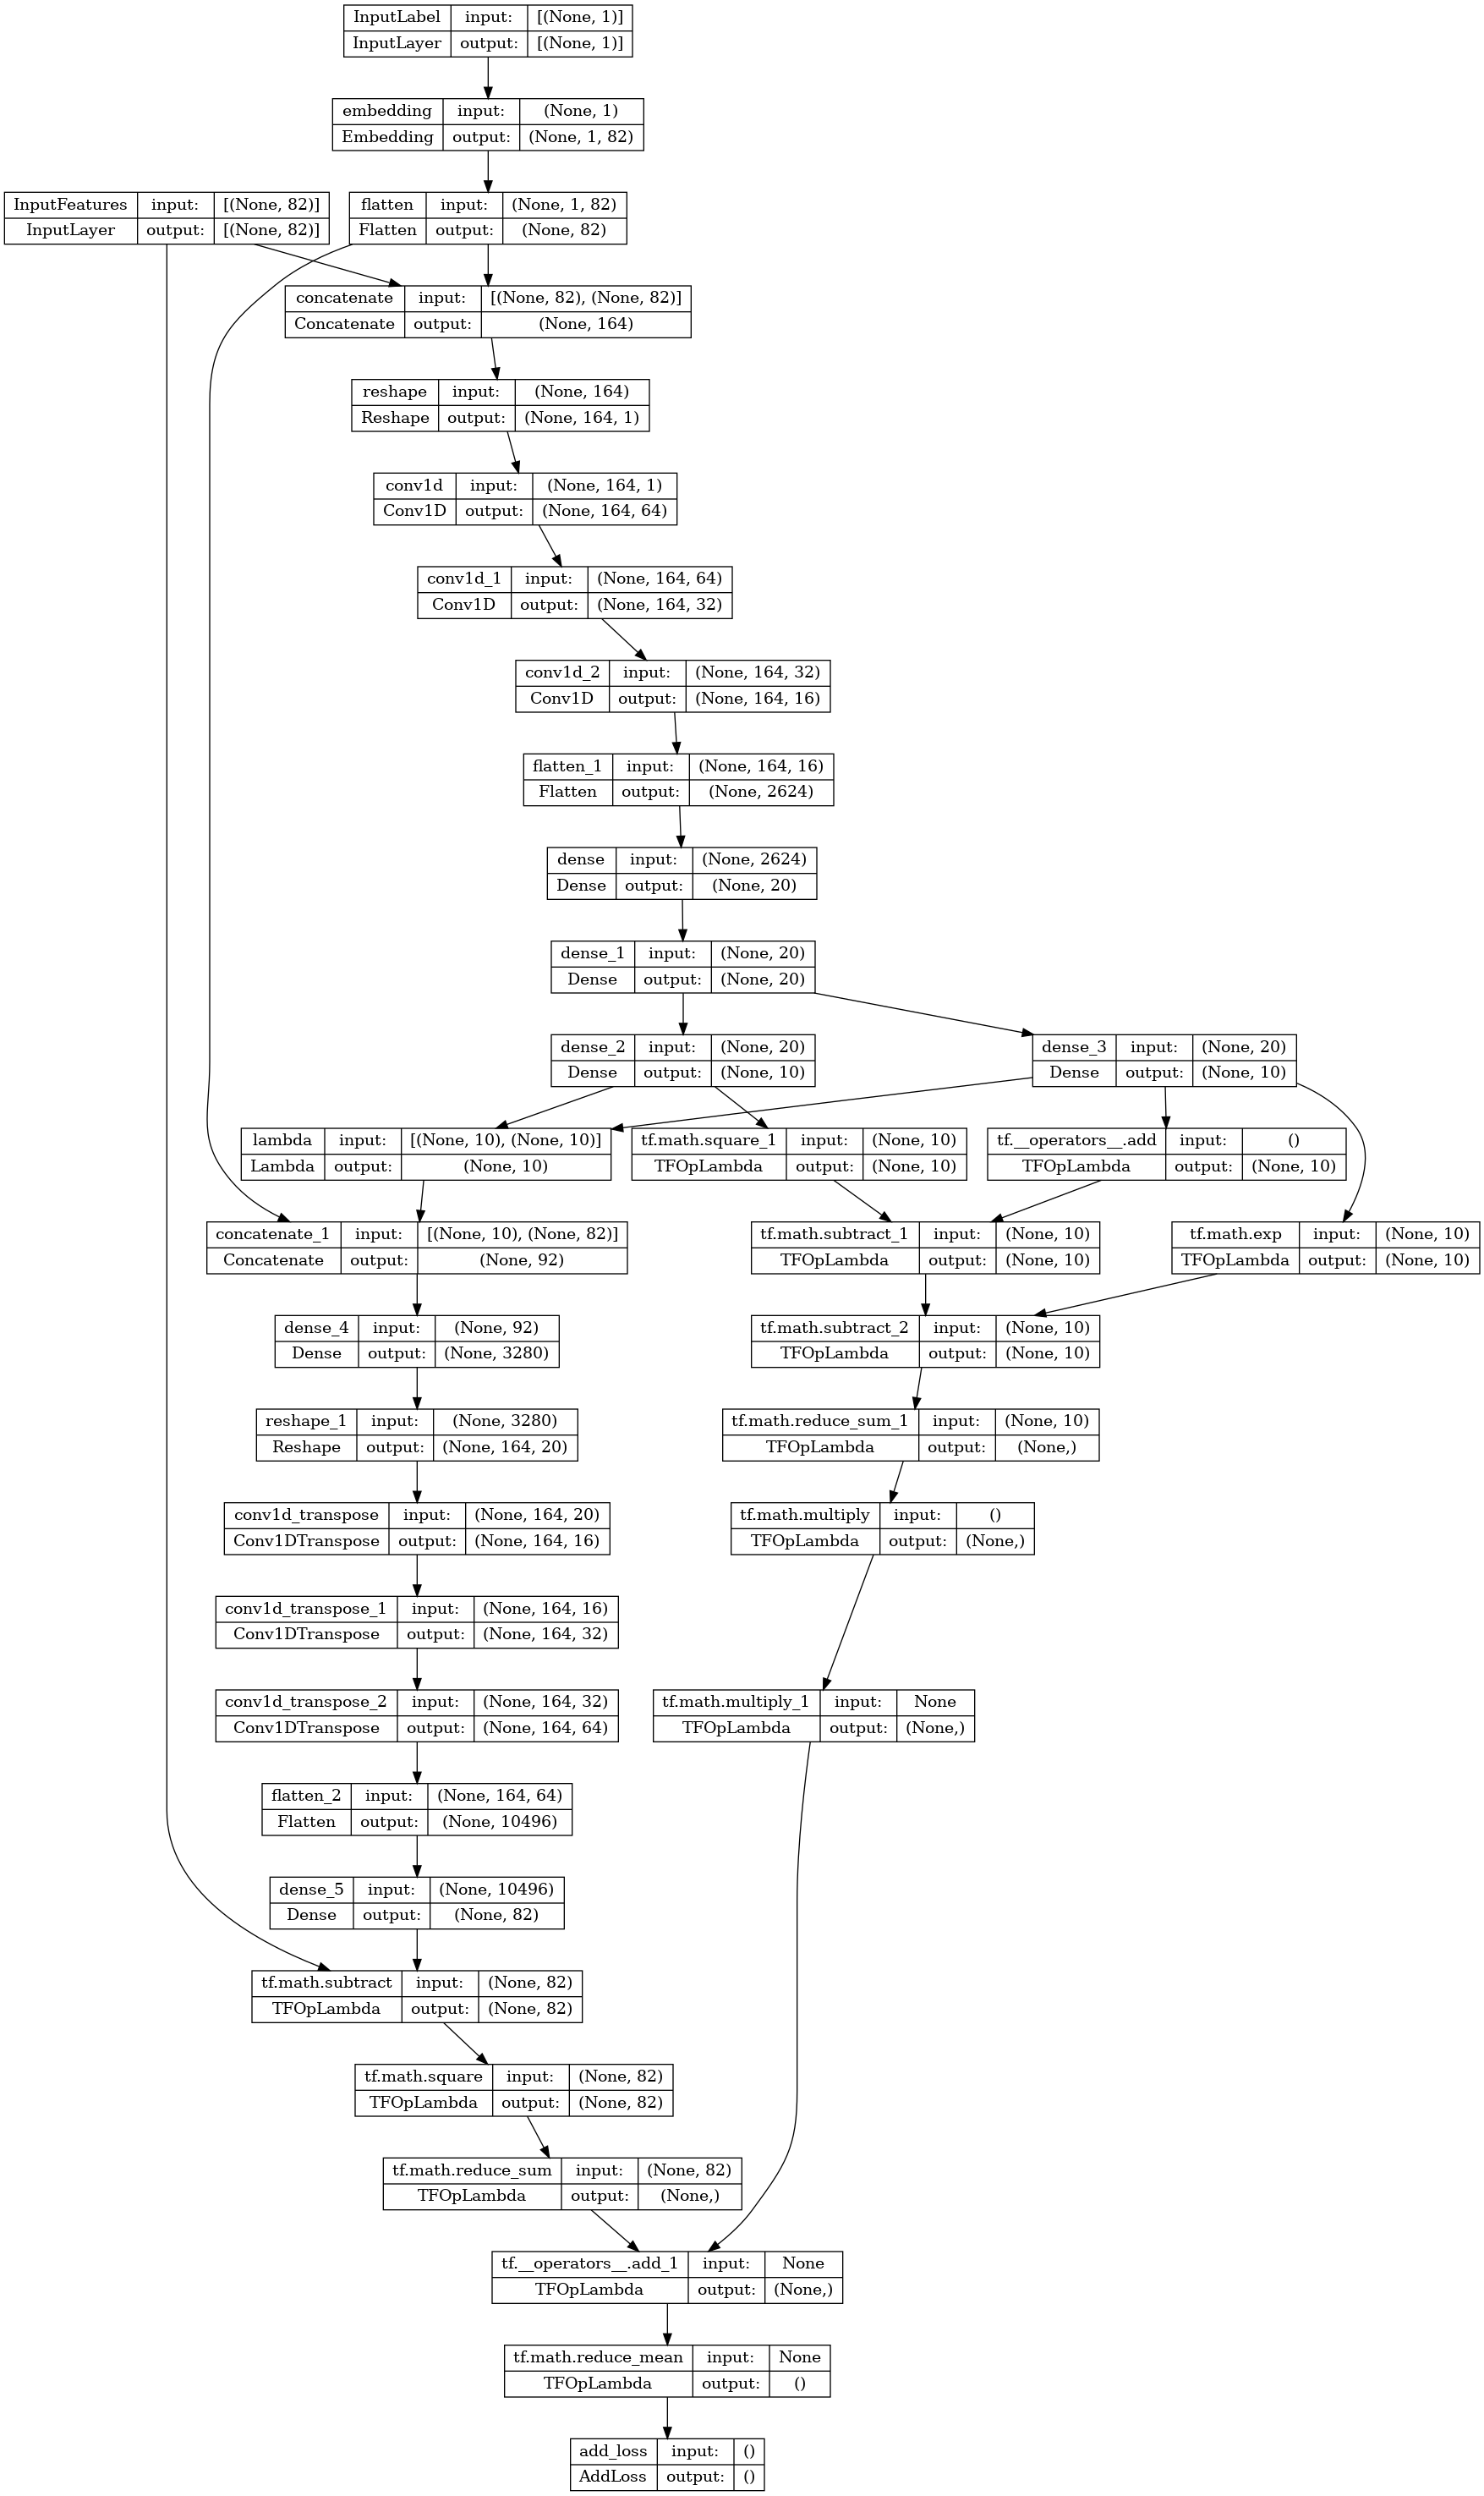

In [29]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_shapes.png', show_shapes=True)

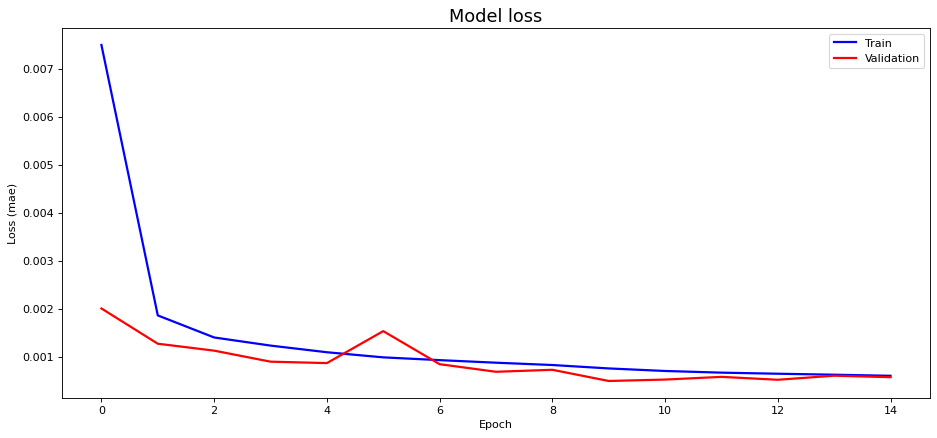

In [30]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [31]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

In [32]:
valid_x_predictions = model.predict([X_test, y_test])
#mse = np.mean(np.power(flatten(test_X_selected) - flatten(valid_x_predictions), 2), axis=1)

mse = np.mean(np.power(X_test - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test.tolist()})

8722/8722 [==============================] - 17s 2ms/step


In [33]:
error_df

,reconstruction_error,true_class
0,0.000250,0
1,0.000653,0
2,0.000264,0
3,0.000030,0
4,0.000278,0
...,...,...
279074,0.002607,1
279075,0.003830,1
279076,0.002226,1
279077,0.002595,1


In [34]:
error_df['reconstruction_error']=error_df['reconstruction_error']*100000

In [35]:
error_df

,reconstruction_error,true_class
0,24.959266,0
1,65.326794,0
2,26.380368,0
3,2.977687,0
4,27.805266,0
...,...,...
279074,260.706649,1
279075,383.000395,1
279076,222.619035,1
279077,259.531934,1


In [36]:
error_df['true_class'].value_counts()

0    159474
1    119605
Name: true_class, dtype: int64

In [37]:
error_df[error_df['true_class']==1]['reconstruction_error'].min()

17.047177553427822

In [69]:
Q4_1 = error_df[error_df['true_class']==1]['reconstruction_error'].quantile(.05)

In [70]:
Q4_1

32.95837079667528

In [40]:
Q4_0 = error_df[error_df['true_class']==0]['reconstruction_error'].quantile(.90)

In [41]:
Q4_0

74.12171470478947

In [42]:
error_df[error_df['true_class']==0]['reconstruction_error'].max()

3080.392570439108

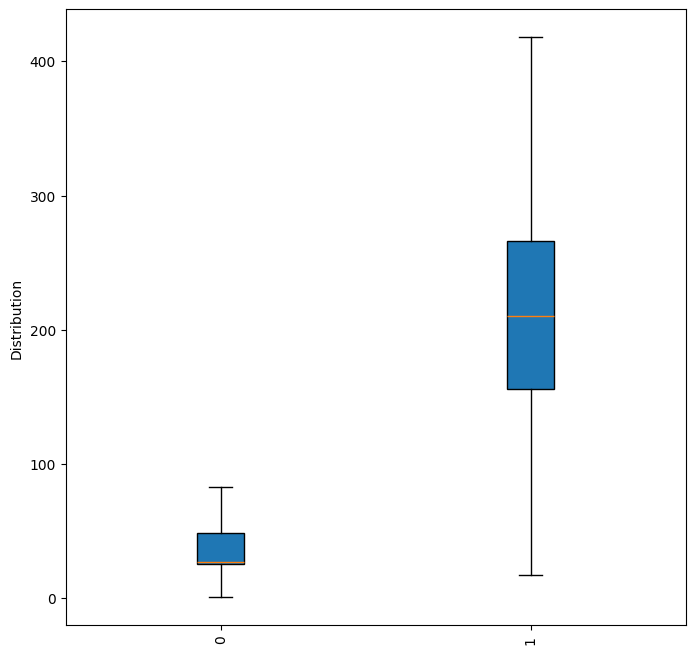

In [43]:
import matplotlib.pyplot as plt

# 데이터프레임 준비
true_class = error_df['true_class'].astype(str)
reconstruction_error = error_df['reconstruction_error']

# 박스 플롯 그리기
plt.figure(figsize=(8, 8))
plt.boxplot(
    [reconstruction_error[true_class == cls] for cls in sorted(true_class.unique())],
    labels=sorted(true_class.unique()),
    showfliers=False,
    vert=True,
    patch_artist=True
)

plt.ylabel('Distribution')
plt.xticks(rotation=90)
plt.show()


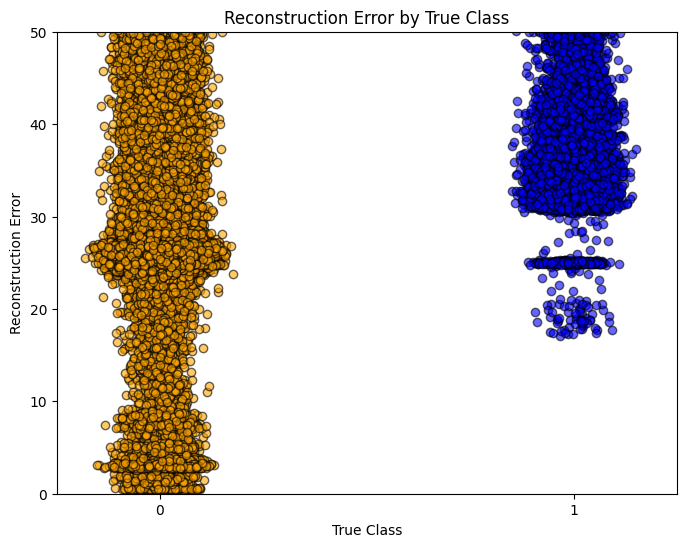

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare the data for plotting
true_class_0 = error_df[error_df['true_class'] == 0]['reconstruction_error']
true_class_1 = error_df[error_df['true_class'] == 1]['reconstruction_error']

# Create the figure and axes with a specified y-axis limit
plt.figure(figsize=(8, 6))

# Add jitter to avoid overlapping points in the scatter plot
x_0 = np.random.normal(1, 0.04, size=len(true_class_0))  # Jitter for class 0
x_1 = np.random.normal(2, 0.04, size=len(true_class_1))  # Jitter for class 1

# Create the scatter plot
plt.scatter(x_0, true_class_0, color='orange', alpha=0.6, edgecolor='black', label='Class 0')
plt.scatter(x_1, true_class_1, color='blue', alpha=0.6, edgecolor='black', label='Class 1')

# Set y-axis limit
plt.ylim(0, 50)

# Set x-axis labels and adjust ticks
plt.xticks([1, 2], ['0', '1'])
plt.xlabel('True Class')

# Set y-axis label and title
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error by True Class')

# Display the plot
plt.show()


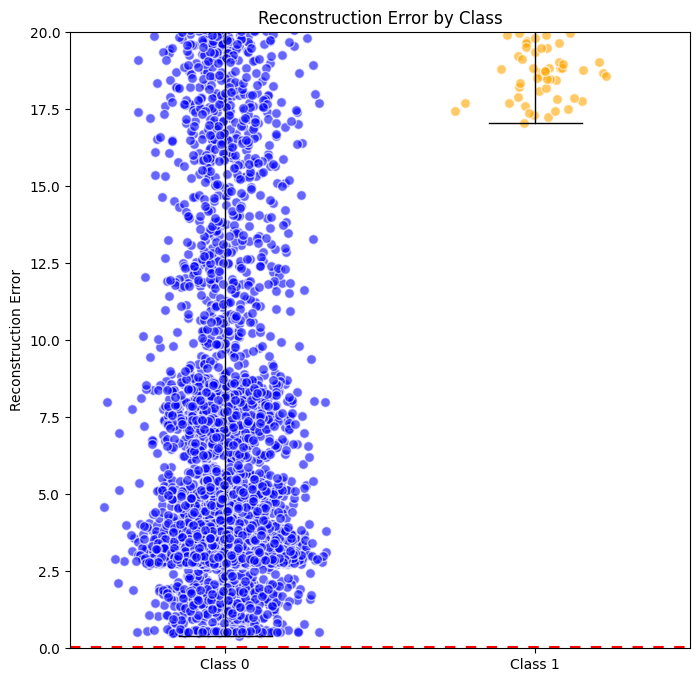

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare the data for plotting
true_class_0 = error_df[error_df['true_class'] == 0]['reconstruction_error']
true_class_1 = error_df[error_df['true_class'] == 1]['reconstruction_error']

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 8))

# Create a swarm plot equivalent using scatter plot with more jitter
x_0 = np.random.normal(1, 0.1, size=len(true_class_0))  # Increased jitter for class 0
x_1 = np.random.normal(2, 0.1, size=len(true_class_1))  # Increased jitter for class 1

ax.scatter(x_0, true_class_0, color='blue', alpha=0.6, label='Class 0', edgecolor='w', s=50)
ax.scatter(x_1, true_class_1, color='orange', alpha=0.6, label='Class 1', edgecolor='w', s=50)

# Create boxplots
ax.boxplot([true_class_0, true_class_1], positions=[1, 2], widths=0.6, patch_artist=True, 
           showfliers=False, boxprops=dict(facecolor='None', color='black'),
           medianprops=dict(color='black'), whiskerprops=dict(color='black'))

# Set x-axis labels
ax.set_xticks([1, 2])
ax.set_xticklabels(['Class 0', 'Class 1'])

# Add a horizontal line at the threshold
ax.axhline(y=0.03, xmin=0.0, xmax=1, dashes=(5, 5), color='red')

# Adjust y-axis limit to make sure the threshold line is visible
#ax.set_ylim(bottom=min(min(true_class_0), min(true_class_1)) - 0.01, 
#           top=max(max(true_class_0), max(true_class_1)) + 0.01)
ax.set_ylim(bottom=0, top=20)
    
# Set labels and title
ax.set_ylabel('Reconstruction Error')
ax.set_title('Reconstruction Error by Class')

plt.show()


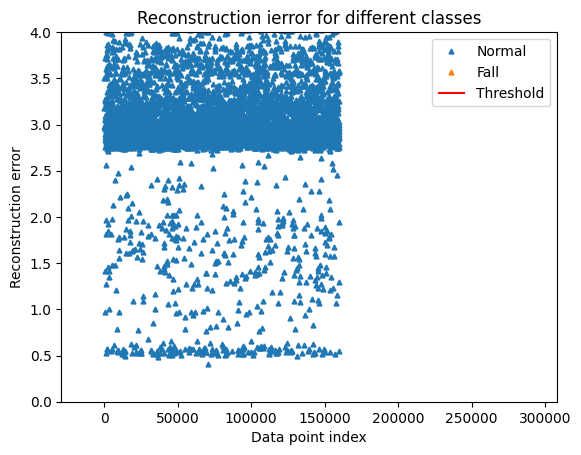

In [74]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='^', ms=3.5, linestyle='',
            label= "Normal" if name == 0 else "Fall")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.set_ylim(0, 4)
ax.legend()
plt.title("Reconstruction ierror for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

<Figure size 1200x1200 with 0 Axes>

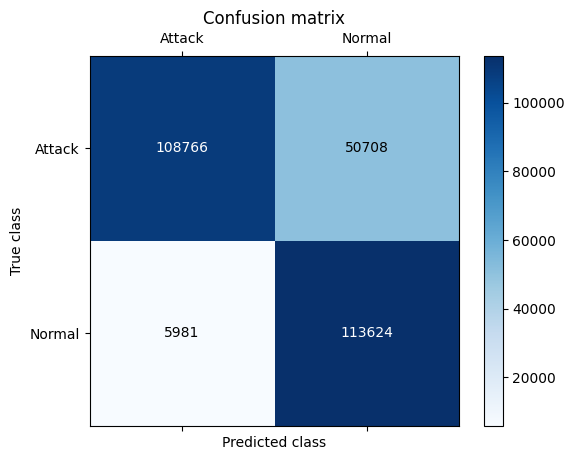

In [75]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming you have already defined LABELS, threshold, and y_pred

LABELS = ["Attack", "Normal"]

y_pred = [0 if e < threshold else 1 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

# Create the figure and axis
plt.figure(figsize=(12, 12))
fig, ax = plt.subplots()

# Plot the confusion matrix using imshow
cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)

# Add color bar
plt.colorbar(cax)

# Set the labels for the axes
ax.set_xticks(np.arange(len(LABELS)))
ax.set_yticks(np.arange(len(LABELS)))

ax.set_xticklabels(LABELS)
ax.set_yticklabels(LABELS)

# Set labels and title
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion matrix')

# Annotate the confusion matrix with the counts
for i in range(len(LABELS)):
    for j in range(len(LABELS)):
        ax.text(j, i, format(conf_matrix[i, j], 'd'),
                ha="center", va="center",
                color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.show()


Best threshold: 92.60000000000089
Best F1 score: 0.8597460951429998


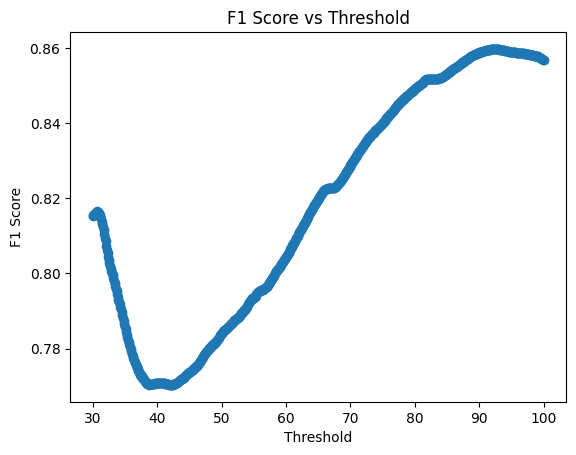

In [88]:


import numpy as np
from sklearn.metrics import f1_score

# Define the range of threshold values
threshold_range = np.arange(30, 100.1, 0.1)

# List to store F1 scores for each threshold
f1_scores = []

# Loop through each threshold and calculate F1 score
for threshold in threshold_range:
    y_pred = [0 if e < threshold else 1 for e in error_df.reconstruction_error.values]
    f1 = f1_score(error_df.true_class, y_pred)
    f1_scores.append(f1)

# Find the threshold with the highest F1 score
best_threshold = threshold_range[np.argmax(f1_scores)]
best_f1_score = max(f1_scores)

print(f"Best threshold: {best_threshold}")
print(f"Best F1 score: {best_f1_score}")

# Optionally, you can plot the F1 scores across the threshold range
plt.plot(threshold_range, f1_scores, marker='o')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.show()


In [89]:
# 그래프 보고 threshold 결정 42.19124597192374
threshold = 92.60000000000089

In [90]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

precision, recall, f1,_ = precision_recall_fscore_support(y_test,y_pred,average='binary')
print ('Accuracy Score :',accuracy_score(error_df.true_class, y_pred) )
print ('Precision :',precision )
print ('Recall :',recall )
print ('F1 :',f1 )

Accuracy Score : 0.886580502295049
Precision : 0.933885194466918
Recall : 0.791379959031813
F1 : 0.8567471793409638


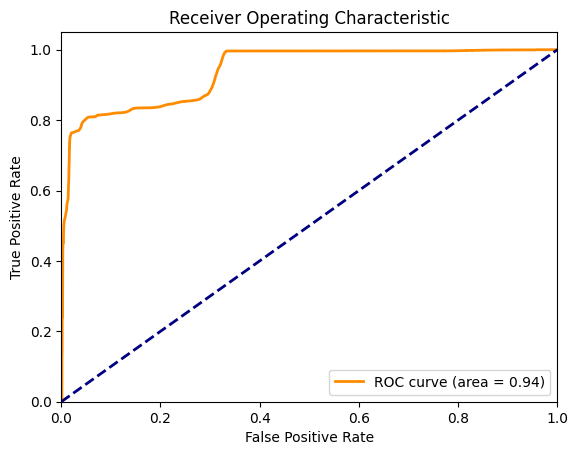

In [91]:
from sklearn.metrics import roc_curve, auc

# Assuming y_test and reconstruction_error have been defined
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


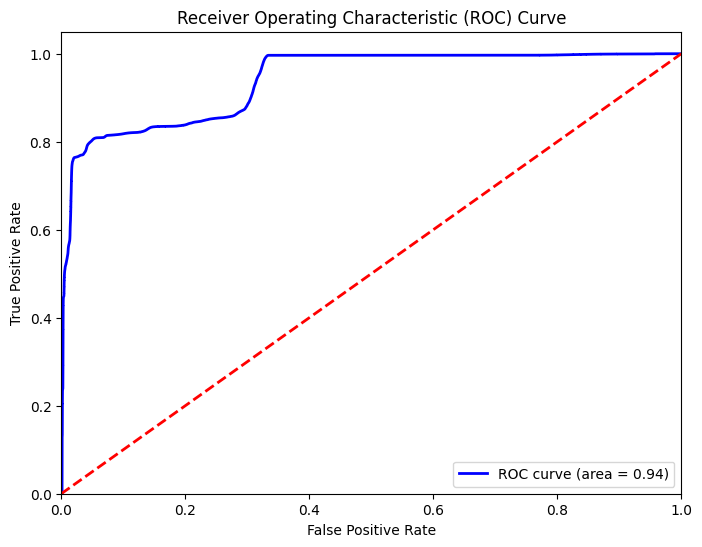

In [92]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Extract the true labels and reconstruction errors from error_df
y_true = error_df['true_class']
y_scores = error_df['reconstruction_error']

# Compute the False Positive Rate (FPR) and True Positive Rate (TPR) for different thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Compute the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')

# Set plot labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Display the plot
plt.show()


In [93]:
# If error_df.true_class is a nested structure, flatten it
y_test = error_df.true_class.apply(lambda x: int(x[0][0]) if isinstance(x, list) else int(x))

# Ensure y_pred is a list of integers
y_pred = [0 if e < threshold else 1 for e in error_df.reconstruction_error.values]

# Now calculate the metrics
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print('Accuracy Score:', accuracy_score(y_test, y_pred))
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)


Accuracy Score: 0.8872577298901028
Precision: 0.9207970896869122
Recall: 0.8062873625684545
F1 Score: 0.8597460951429998


In [94]:
print(roc_auc)

0.9390982611931349
